In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True

In [ ]:
import sys
sys.path.append("..")

from ggqpy import construct_Chebyshev_quadratures
from ggqpy.functionfamiliy import Interval, FunctionFamily
from ggqpy.testproblems import example_problem, gen_poly_and_sing
from ggqpy.discretize import Discretizer
from ggqpy.compress import compress_sequence_of_functions, visualise_diagonal_dropoff, construct_A_matrix, interp_legendre
from ggqpy.optimize import QuadOptimizer
from ggqpy.visualize import plot_points

In [2]:
gamma = (
    lambda r0, theta0, u: r0
    * np.sin(theta0)
    / (r0 * np.sin(theta0 - theta0 * u) + np.sin(theta0 * u))
)
number_of_parameters = 16

x_gl, _ = np.polynomial.legendre.leggauss(number_of_parameters)

(amin, amax) = (1e-7, 1)
alphas = (amax - amin) * (x_gl + 1) / 2 + amin

(bmin, bmax) = (1e-7, np.pi)
betas = (bmax - bmin) * (x_gl + 1) / 2 + bmin

n = 2
functions_cos = [
    lambda u, alpha=alpha, beta=beta: beta
    * gamma(alpha, beta, u) ** (i + 2)
    / (i + 2)
    * np.cos(j * beta * u)
    for i in range(-1, n + 1)
    for j in range(0, 3 * (i + 1) + 2 + 1)
    for alpha in alphas
    for beta in betas
]
functions_sin = [
    lambda u, alpha=alpha, beta=beta: beta
    * gamma(alpha, beta, u) ** (i + 2)
    / (i + 2)
    * np.sin(j * beta * u)
    for i in range(-1, n + 1)
    for j in range(0, 3 * (i + 1) + 2 + 1)
    for alpha in alphas
    for beta in betas
]

functions = functions_cos + functions_sin

F = FunctionFamily(
    Interval(0, 1), None, functions
)
print(len(functions))

15360


In [3]:
interpolation_degree=10
eps_disc = 1e-5
eps_comp = 1e2*eps_disc
eps_quad = 1e-2
disc = Discretizer(precision=eps_disc, min_length=1e-1, interpolation_degree=interpolation_degree, verbose=False)
x_disc, w_disc, endpoints, intervals = disc.adaptive_discretization(F)

  8%|▊         | 1199/15360 [00:05<01:02, 225.07it/s]


KeyboardInterrupt: 

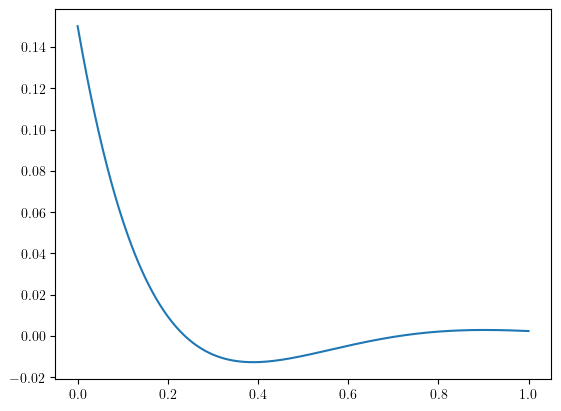

In [ ]:
xx = np.linspace(0,1,1000)
plt.plot(xx,functions[100](xx))

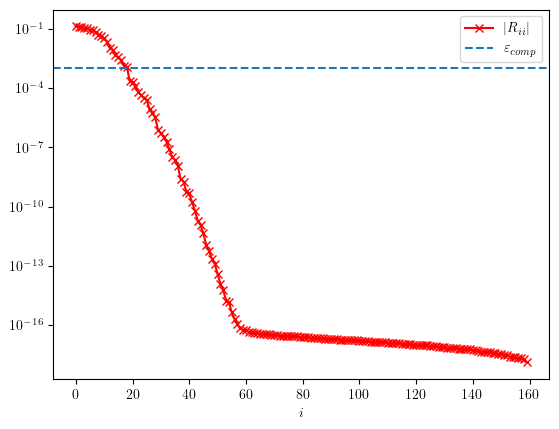

In [ ]:
A = construct_A_matrix(x_disc,w_disc,F.functions)
visualise_diagonal_dropoff(A, eps_comp)

In [ ]:
U_disc, rank = compress_sequence_of_functions(F.functions, x_disc, w_disc, eps_comp)

In [ ]:
(x_cheb,),w_cheb = construct_Chebyshev_quadratures((x_disc,),w_disc,U_disc)

In [ ]:
print(x_cheb)

[2.14731275e-04 1.12587727e-03 9.99785269e-01 2.74267412e-03
 9.98874123e-01 7.92712792e-03 9.94972405e-01 1.95716847e-02
 9.80428315e-01 6.34565815e-01 3.84565815e-01 2.95493290e-01
 4.29283153e-02 5.45493290e-01 1.82717092e-01 8.35856631e-01
 7.18291488e-01 9.61414538e-02 9.22214594e-01]


In [ ]:
u_list = interp_legendre(U_disc, interpolation_degree, intervals)
r = U_disc.T@w_disc
opt = QuadOptimizer(u_list,r)
x,w = opt.point_reduction(x_cheb, w_cheb, eps_quad)

KeyboardInterrupt: 

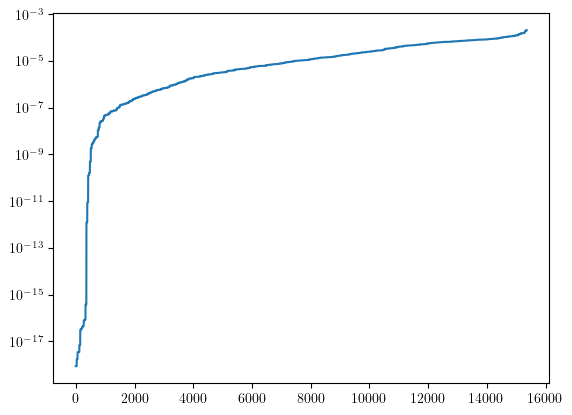

In [ ]:
f = functions[1]
err = [abs(f(x_disc)@w_disc - f(x)@w) for f in functions]
plt.semilogy(sorted(err))

In [ ]:
print(w)

[0.00140608 0.00563189 0.00854218 0.04500414 0.13600215 0.2000539
 0.19780926 0.05117129 0.21955501 0.13437391]
